<a href="https://colab.research.google.com/github/ManishaKakkireni/Kidney-Stones-detection/blob/main/Kidney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kaggle

In [2]:
!pip install -q kaggle

import json
import os

# Save your Kaggle API token
kaggle_token = {
    "username": "manishakakkireni",
    "key": "ff21b296409eb79606df567a2d7e9d76"
}

os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(kaggle_token, file)
os.chmod('/root/.kaggle/kaggle.json', 0o600)


In [3]:
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

import zipfile

with zipfile.ZipFile("ct-kidney-dataset-normal-cyst-tumor-and-stone.zip", 'r') as zip_ref:
    zip_ref.extractall("ct_kidney_dataset")


Dataset URL: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
License(s): copyright-authors
 99% 1.51G/1.52G [00:12<00:00, 103MB/s]
100% 1.52G/1.52G [00:15<00:00, 104MB/s]


In [4]:
import os

def find_class_folders(base_dir, class_names):
    for root, dirs, files in os.walk(base_dir):
        if all(cls in dirs for cls in class_names):
            return root
    raise Exception(f"Could not find folders: {class_names} under {base_dir}")

# Automatically find the path that contains both 'Stone' and 'Normal' folders
original_path = find_class_folders("ct_kidney_dataset", ['Stone', 'Normal'])
print(f"✅ Found class folders at: {original_path}")


✅ Found class folders at: ct_kidney_dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone


In [5]:
import shutil
from sklearn.model_selection import train_test_split
import glob

binary_dataset_path = 'kidney_stone_binary_dataset'

# Create train/test folders
for split in ['train', 'test']:
    for cls in ['Stone', 'Normal']:
        os.makedirs(os.path.join(binary_dataset_path, split, cls), exist_ok=True)

# Move files into train/test
for cls in ['Stone', 'Normal']:
    files = glob.glob(os.path.join(original_path, cls, '*'))
    print(f"{cls}: Found {len(files)} images")

    if len(files) == 0:
        raise Exception(f"No files found in {cls} folder. Check folder path.")

    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

    for f in train_files:
        shutil.copy(f, os.path.join(binary_dataset_path, 'train', cls))
    for f in test_files:
        shutil.copy(f, os.path.join(binary_dataset_path, 'test', cls))


Stone: Found 1377 images
Normal: Found 5077 images


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 64
BATCH_SIZE = 32

train_path = 'kidney_stone_binary_dataset/train'
test_path = 'kidney_stone_binary_dataset/test'

Train_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_path, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary')

Test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary')

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Train_data, epochs=3, validation_data=Test_data)


Found 5162 images belonging to 2 classes.
Found 1292 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
162/162 ━━━━━━━━━━━━━━━━━━━━ 65s 385ms/step - accuracy: 0.8507 - loss: 0.3436 - val_accuracy: 0.9969 - val_loss: 0.0228
Epoch 2/3
162/162 ━━━━━━━━━━━━━━━━━━━━ 56s 344ms/step - accuracy: 0.9976 - loss: 0.0101 - val_accuracy: 0.9876 - val_loss: 0.0420
Epoch 3/3
162/162 ━━━━━━━━━━━━━━━━━━━━ 86s 369ms/step - accuracy: 0.9987 - loss: 0.0076 - val_accuracy: 1.0000 - val_loss: 3.4822e-04


Saving 98019fb804d3b49589086ffc3db1c8.jpg to 98019fb804d3b49589086ffc3db1c8.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


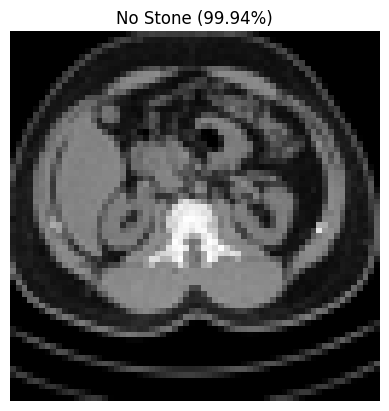

In [7]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()

for file_name in uploaded.keys():
    img = Image.open(file_name).resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    label = "Stone Detected" if prediction > 0.5 else "No Stone"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{label} ({confidence:.2%})")
    plt.show()
